## Creating a mini data set

Let's start by creating a set of numbers that we can use for this experiment. We *could* just choose numbers from a random distribution. But since in climate, our data has some structure in space and time, let's ensure that our experiment data does as well. This will also make it easier to see (in a picture/plot/animation) whether we have done anything silly, like slice the wrong axis, or get things out of order.

We'll try and make something trippy like a 2 dimensional sine wave radiating out from some spot that's *not* the exact center. We want to make it easy to detect a reflected axis.

First we'll import a few things that we'll need: `numpy` for all of the numerical array access and `matplotlib` for the visualization. If we set `matplotlib` to plot "inline", it will show us our plots directly beneath our code.

In [1]:
import os
import numpy as np
import math
import matplotlib
from matplotlib import pyplot
%matplotlib inline

Next we simply create an empty array. We'll create an array of 32-bit floats (4 bytes each), and we'll make around 256 million of them. That will make our array size a nice round 1 GB.

In [2]:
shape = (256, 1024, 1024)
my_array = np.empty(shape, dtype='float32')
my_array.shape

(256, 1024, 1024)

### Compute some trippy data

We'll define our mapping function to essentially compute a distance from an origin (256, 256), and then increase the wavelength a little bit $ \frac{d}{4} $ so that we have a few oscillations radiating out on the plot.

We'll compute the first "timestep", and then add another sine wave on that through time. This should give us something trippy, yet identifiable.

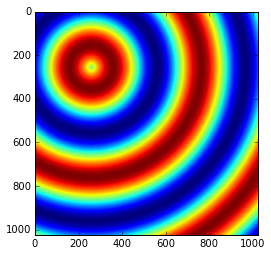

In [3]:
def f(x, y, z):
    d = math.sqrt((x - 256) ** 2 + (y - 256) ** 2)
    return math.sin(d / 64) + math.sin(z)
f_v = np.vectorize(f)

x, y = np.meshgrid(range(my_array.shape[2]), range(my_array.shape[1]))
basegrid = f_v(x, y, 0)

for z in range(my_array.shape[0]):
    my_array[z,:,:] = basegrid + math.sin(z / 32)

pyplot.imshow(my_array[0,:,:])

In [4]:
print(np.min(my_array), np.max(my_array))
print(my_array.shape)

-1.99998 1.99997
(256, 1024, 1024)


### Animate this

Now we'll create a little animation, just to take a look and give us some idea of the structure of our data.

In [5]:
from matplotlib import animation
from matplotlib.colors import Normalize
from IPython.display import HTML

def do_animation(array):

    amax, amin = np.max(array), np.min(array)
    normalizer = Normalize(amin, amax)
    ny, nx = array.shape[1:3]
    fig = pyplot.figure()
    ax = pyplot.axes(xlim=(0, nx), ylim=(0, ny))
    img = ax.imshow(array[0,:,:], norm=normalizer, origin='lower', interpolation=None)
    
    def init():
        img.set_data(array[0,:,:])
        return img,

    def animate(i):
        img.set_data(array[i,:,:])
        return img,
    
    return animation.FuncAnimation(fig, animate, init_func=init, frames=array.shape[0], interval=1, blit=True)

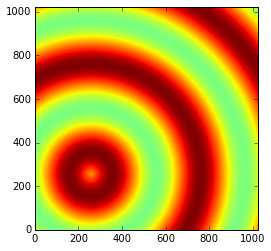

In [6]:
anim = do_animation(my_array)
anim.save('random_sine_wave.mp4', writer='ffmpeg', fps=10, extra_args=['-vcodec', 'libx264'])
HTML("""<video controls>
 <source src="random_sine_wave.mp4" type="video/mp4">
 Your browser does not support the video tag.
</video>""")

### Writing it out to disk

I know that we're supposed to be talking about *NetCDF* I/O, but for now, let's just forget about NetCDFs. They are just a big multidimensional array and those aren't actually that difficult to deal with. Let's build up all of our I/O operations first, ensure that we know how to use them properly and how they behave in a memory limited environment and *then* we'll move on to using the NetCDF API and operations.

Let's just write it as a raw, binary file (this will probably be the first and *last* time that I every advocate for using a raw, binary file).

In [7]:
from tempfile import NamedTemporaryFile

def array_to_disk(array):
    with NamedTemporaryFile(dir=os.getcwd(), suffix='.bin', delete=False) as f:
        pass
    array.tofile(f.name)
    return f.name

In [8]:
filename = array_to_disk(my_array)

Now if we check the size of the file:

In [9]:
!ls -lh $filename

-rw------- 1 james james 1.0G May  1 08:50 /home/james/code/git/netcdf-tutorial/notebooks/tmpcaj_pi.bin


We see that it is exactly 1.0 gigabytes, just as we computed eariler. No headers, no extra stuff, just raw bytes, and not a byte extra.

## Raw File I/O

OK let's start with some raw file I/O and see how fast we can expect reads to our array to be. Just a plain old sequential read to a (presumably) sequential file. This will be our baseline.

In [10]:
!time cat $filename > /dev/null
!time dd if=$filename of=/dev/null bs=65536


real	0m0.117s
user	0m0.000s
sys	0m0.110s
16384+0 records in
16384+0 records out
1073741824 bytes (1.1 GB) copied, 0.10171 s, 10.6 GB/s

real	0m0.102s
user	0m0.000s
sys	0m0.100s


In [11]:
{'cat': 2**30 / .105 / (1024 ** 2), 'dd_64k': 2 ** 30 / .103 / (1024 **2)}

{'cat': 9752.380952380952, 'dd_64k': 9941.747572815535}

So our basic command line tools can read at about 10 GB/sec. What about Python?

In [12]:
%%timeit
with open(filename, 'rb', buffering = 64 * 1024) as f, open('/dev/null', 'wb') as w:
    while True:
        bytes = f.read(65536)
        if bytes:
            pass#w.write(bytes)
        else:
            break

10 loops, best of 3: 120 ms per loop


In [13]:
{'python3.3': 2**30 / .118 / (1024 ** 2)}

{'python3.3': 8677.966101694916}

So Python is on par, maybe a little slower. Let this be our baseline.

In [14]:
class DataCubeFile(object):
    def __init__(self, filename, shape):
        self.f = open(filename, 'rb')
        self.shape = shape
    
    def __getitem__(self, slices):
        assert len(slices) == len(self.shape)
        for slice_ in slices:
            if slice_.step:
                raise NotImplementedError("Using steps on a DataCubeFile are not implemented")

        zn, yn, xn = self.shape

        retval = np.empty((slices[0].stop - slices[0].start,
                           slices[1].stop - slices[1].start,
                           slices[2].stop - slices[2].start), dtype='float32')
        
        for z, zi in enumerate(range(slices[0].start, slices[0].stop)):
            for y, yi in enumerate(range(slices[1].start, slices[1].stop)):
                xi = slices[2].start
                
                starting_position = ((zi * yn * xn) + yi * xn + xi) * np.dtype('float32').itemsize
                read_length = (slices[2].stop - slices[2].start) * np.dtype('float32').itemsize
                if self.f.tell() != starting_position:
                    self.f.seek(starting_position)
                bytes = self.f.read(read_length)
                #print("Reading {} bytes from {}".format(read_length, starting_position))
                assert len(bytes) == read_length
                retval[z,y,:] = np.fromstring(bytes, np.dtype('float32'))
        return retval

In [15]:
cube = DataCubeFile(filename, (256, 1024, 1024))
cube.shape

(256, 1024, 1024)

(1, 512, 512)


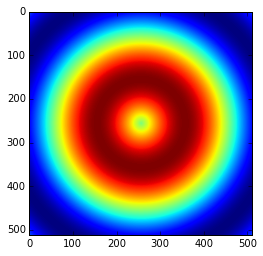

In [16]:
c = cube[0:1, 0:512, 0:512]
print(c.shape)
pyplot.imshow(c[0,:,:])

(1, 512, 512)


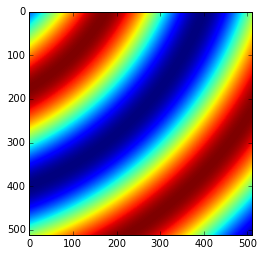

In [17]:
c = cube[0:1, 512:1024, 512:1024]
print(c.shape)
pyplot.imshow(c[0,:,:])

In [18]:
from time import time
from contextlib import ContextDecorator

class ThroughputMeter(ContextDecorator):
    def __enter__(self):
        self.t0 = time()
        return self
    def __exit__(self, *exc):
        self.tn = time()

    def megabytes_per_second(self, array):
        seconds = self.tn - self.t0
        MB = np.prod(array.shape) / 1024 ** 2 * array.dtype.itemsize
        MBps = MB / seconds
        print("{:03.3f} MB in {:03.3} seconds at {:03.3f} MB / sec".format(MB, seconds, MBps))
        return MBps


With a data file to query, an interface to subset it, and a function to record some metrics, we can run experiments and measure the read rates and and ensure that it behaves the way we expect it to. Essentially our hypothesis is that:

> Read rate will decrease with slice fragmentation

To test this hypothesis, we'll measure the read rate for several slices in increasing order of fragmentation.

* The entire file (least fragmentation)
* One contiguous row at each time step
* A spatial square subset (contiguous in space, but not memory)
* The full timeseries of a single cell (most fragmentation)

### Read rate for full file

In [19]:
with ThroughputMeter() as t:
    c = cube[0:256, 0:1024, 0:1024]
t.megabytes_per_second(c)

1024.000 MB in 3.27 seconds at 313.441 MB / sec


313.44125106558067

### Read rate for one full row slice and full timeseries

In [20]:
with ThroughputMeter() as t:
    c = cube[0:256, 5:6, 0:1024]
t.megabytes_per_second(c)

1.000 MB in 0.0304 seconds at 32.889 MB / sec


32.888763428212968

### Read rate for a 1/16 slice in space full timeseries

In [21]:
with ThroughputMeter() as t:
    c = cube[0:256, 0:128, 768:1024]
t.megabytes_per_second(c)

32.000 MB in 0.401 seconds at 79.855 MB / sec


79.85476206483564

### Read rate for a single cell and full timeseries

In [22]:
with ThroughputMeter() as t:
    c = cube[0:256, 0:1, 512:513]
t.megabytes_per_second(c)

0.001 MB in 0.00467 seconds at 0.209 MB / sec


0.20896893015662465

In [23]:
c.dtype

dtype('float32')

## Can't we just do this in RAM?

In [24]:
class DataCubeArray(object):
    def __init__(self, filename, shape):
        self.array = np.fromfile(filename, np.dtype('float32')).reshape(shape)
        self.shape = shape

    def __getitem__(self, slices):
        return self.array[slices]

In [25]:
acube = DataCubeArray(filename, (256, 1024, 1024))


In [26]:
with ThroughputMeter() as t:
    c = acube[0:256, 0:1024, 0:1024]
t.megabytes_per_second(c)

1024.000 MB in 1.03e-05 seconds at 99882960.372 MB / sec


99882960.372093022

Heeeeeey, now we're talking. After paying a one-time read penalty on the first access, we just returned the entire array in under a microsecond. Those are the kind of speeds that we're after, especially when we're doing repeated access to the same set of data. Other array access in memory is of similar speed

In [27]:
with ThroughputMeter() as t:
    c = acube[0:256, 5:6, 0:1024]
t.megabytes_per_second(c)

1.000 MB in 1.19e-05 seconds at 83886.080 MB / sec


83886.080000000002

In [28]:
with ThroughputMeter() as t:
    c = acube[0:256, 0:1, 512:513]
t.megabytes_per_second(c)

0.001 MB in 1.14e-05 seconds at 85.333 MB / sec


85.333333333333329

## Wait... we don't have that much RAM

Hold on, hold on. Now that we've gotten all excited about how fast we can access the array, it turns out that RAM is limited. Who knew?! Right now we have a 1GB file and more RAM than that, but what if we had less... say we only had 1MB of RAM? We commonly have NetCDF files that are upwards of tens to hundreds of GB and 10-100 times the amount of RAM that we can (or at least *should* use). So, how about we artifically limit the RAM we have and then reevaluate our strategy. To limit our RAM we have to screw around with Operating System configuration.

We'll pause here, go and discuss usage of the NetCDF library, and then come back to how we can work within a RAM limited environment.